# HHI of Stargaze network

In [114]:
import json
from typing import List
import requests
from funcy import compose
import pandas as pd
from jupyterthemes import jtplot


Get the state of all validators.

In [145]:
def validators (rpc):
    return requests.get(f'{rpc}/validators').json()['result']['validators']

stargaze_rpc = 'http://173.255.240.182:26657'
voting_powers(validators(stargaze_rpc))

[3687612,
 3571363,
 3559911,
 3526680,
 3507479,
 3470072,
 3438331,
 3387953,
 3302198,
 2904779,
 2638700,
 2500790,
 2367078,
 2334335,
 2257743,
 2230625,
 2103199,
 2102500,
 2012875,
 2006079,
 1990575,
 1964922,
 1928267,
 1838491,
 1823659,
 1786100,
 1700000,
 1699142,
 1691783,
 1688970]

Get the delegation associated with each validator.

In [146]:
def voting_powers (validators: List) -> List[int]:
    tokens = [int(v['voting_power']) for v in validators]
    return tokens

assert(len(voting_powers(validators(stargaze_rpc)))>1)

In [147]:
def values_to_marketshares (values: List[int]) -> List[float]:
    '''
    Takes value of each firm and turns it into a proportion, i.e., 
    their share of the total market.
    '''
    total = sum(values)
    return [v / total for v in values ]

assert(values_to_marketshares([10, 10, 30]) == [0.2, 0.2, 0.6])

In [148]:
def hhi (marketshares: List[float]):
    '''
    "The HHI is calculated by squaring the market share of each firm competing in the market 
    and then summing the resulting numbers."
    
    U.S. federal agencies "generally consider markets in which the HHI is between 
    1,500 and 2,500 points to be moderately concentrated, and consider markets 
    in which the HHI is in excess of 2,500 points to be highly concentrated."
    
    From https://www.justice.gov/atr/herfindahl-hirschman-index
    '''
    squares = [(x*100)*(x*100) for x in marketshares]
    return sum(squares)
    
assert(hhi([.30, .30, .20, .20]) == 2600)

In [149]:
network_hhi = compose(hhi, values_to_marketshares, voting_powers, validators)

stargaze_hhi = network_hhi(stargaze_rpc)
stargaze_hhi

360.0377038539479

## Compare to other networks

In [150]:
# oasis
def hhi_smartstake (url):
    validators = requests.get(url).json()['data']
    values = [v['totalShares'] for v in validators]
    return hhi(values_to_marketshares(values))

hhi_smartstake('https://oprod.smartstakeapi.com/listData?type=oasisPools&selectedInd=True&key=2mwTEDr9zXJH323M&token=1640710779&app=OASIS')

214.43644256819695

In [153]:
hhis = {
    'Stargaze': network_hhi(stargaze_rpc),
    'Juno': network_hhi('http://45.79.74.220:26657'),
    'Cosmos Hub': network_hhi('https://cosmoshub.validator.network:443'),
    'Osmosis': network_hhi('https://rpc-osmosis.keplr.app'),
    'Akash': network_hhi('https://rpc-akash.keplr.app'),
    'Regen':  network_hhi('https://rpc-regen.keplr.app'),
    'Sentinel': network_hhi('https://rpc-sentinel.keplr.app'),
    'Oasis': hhi_smartstake('https://oprod.smartstakeapi.com/listData?type=oasisPools&selectedInd=True&key=2mwTEDr9zXJH323M&token=1640710779&app=OASIS'),
    'Terra': hhi_smartstake('https://ucyy8jicu2.execute-api.us-east-1.amazonaws.com/prod/listData?type=listPools&status=Bonded&key=2mwTEDr9zXJH323M&token=1640710965&app=TERRA')
}

Text(0, 0.5, 'HHI')

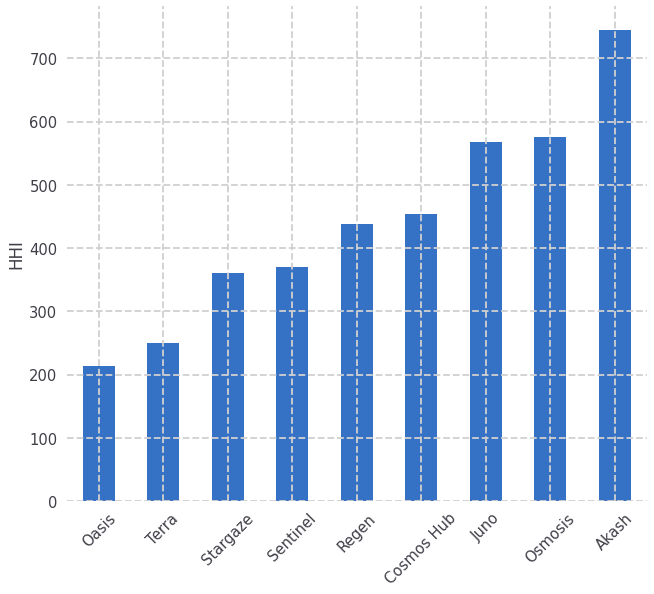

In [154]:
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

ax = pd.Series(hhis).sort_values().plot.bar(rot=45)
ax.set_ylabel('HHI')